In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import nltk; nltk.download('stopwords')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
import openpyxl
from gensim.models import CoherenceModel
import tqdm

In [3]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(il_ilce)

In [4]:
df = pd.read_excel("Policy_Actions.xlsx")

In [5]:
df.columns

Index(['City \n(*innovator)', 'Land-use Policy/Planning '], dtype='object')

In [6]:
data= df["Policy_A"]

In [7]:
# Remove punctuation
data.map(lambda x: re.sub('[,\.!?;/]', '', x))
# Convert the titles to lowercase
data = \
data.map(lambda x: x.lower())
# Print out the first rows of papers
data.head()
data = data.values.tolist()

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=20) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=20)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['energy', 'promotion', 'of', 'clean', 'and', 'renewable_energy', 'initative', 'funding', 'awareness', 'campaigns', 'encourage', 'renewable_energy', 'in', 'public', 'residential', 'buildings', 'and', 'social', 'sites', 'schools', 'hospitals', 'etc', 'mobility', 'support', 'the', 'creation', 'of', 'pedestrian', 'and', 'cycleable', 'infrastructure', 'establishment', 'of', 'pedestrian', 'zones', 'study', 'the', 'establishment', 'of', 'low', 'emission_zone', 'support', 'the', 'development', 'of', 'multimodal', 'transport', 'systems', 'green_spaces', 'target', 'plant', 'trees', 'green', 'plan', 'project', 'agriculture', 'promote', 'the', 'development', 'of', 'urban', 'and', 'peri', 'urban', 'agriculture']


In [10]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
spacy.load('en_core_web_sm')

In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['energy', 'promotion', 'clean', 'renewable_energy', 'initative', 'funding', 'awareness', 'campaign', 'encourage', 'renewable_energy', 'public', 'residential', 'building', 'social', 'site', 'school', 'hospital', 'mobility', 'support', 'creation', 'pedestrian', 'cycleable', 'infrastructure', 'establishment', 'pedestrian', 'zone', 'study', 'establishment', 'low', 'support', 'development', 'multimodal', 'transport', 'system', 'space', 'target', 'plant', 'tree', 'green', 'plan', 'project', 'agriculture', 'promote', 'development', 'urban', 'agriculture']]


In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]]


In [14]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=10,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"energy" + 0.022*"upgrade" + 0.021*"walk" + 0.021*"corridor" + '
  '0.018*"mobility" + 0.017*"target" + 0.015*"solar" + 0.015*"city" + '
  '0.014*"roof" + 0.014*"infrastructure"'),
 (1,
  '0.030*"action" + 0.030*"target" + 0.023*"mobility" + 0.023*"agriculture" + '
  '0.023*"green" + 0.023*"space" + 0.023*"cycle_path" + 0.023*"km" + '
  '0.015*"encourage" + 0.015*"waste"'),
 (2,
  '0.023*"target" + 0.022*"bicycle" + 0.022*"promote" + 0.022*"increase" + '
  '0.022*"green" + 0.022*"waste" + 0.022*"urban" + 0.015*"energy" + '
  '0.015*"lane" + 0.015*"community"'),
 (3,
  '0.045*"target" + 0.022*"bike" + 0.021*"expand" + 0.020*"solar" + '
  '0.019*"green" + 0.016*"own" + 0.016*"community" + 0.016*"installation" + '
  '0.016*"space" + 0.015*"park"'),
 (4,
  '0.038*"policy" + 0.020*"action" + 0.020*"bicycle" + 0.020*"develop" + '
  '0.020*"include" + 0.020*"example" + 0.020*"use" + 0.020*"land" + '
  '0.020*"strict" + 0.020*"electrify"'),
 (5,
  '0.039*"target" + 0.034*"green" 

In [16]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.493113695830584

Coherence Score:  0.4502370778194325


In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model=gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, iterations=750,chunksize=100,passes=10,)

        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                            passes=10,
                                           alpha=0.91,
                                           eta='symmetric',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [18]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=12, limit=40, step=2)

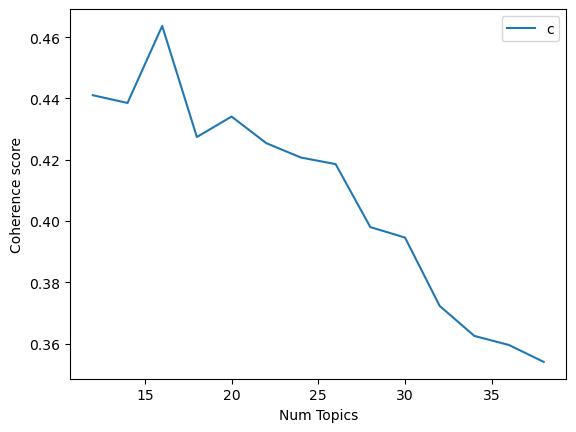

In [19]:
import matplotlib.pyplot as plt
limit=40; start=12; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [20]:
coherence_values

[0.4410444029152074,
 0.4385167299803336,
 0.46366169317045197,
 0.427412910312005,
 0.4340831300218001,
 0.42540800793370986,
 0.4207099101136555,
 0.4185619945670172,
 0.3980144196867446,
 0.3945971420848596,
 0.372282406254294,
 0.3624909272526098,
 0.3595226471804019,
 0.35400953451145184]

In [21]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=22, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta='auto',
                                           per_word_topics=True)

In [22]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(21,
  '0.001*"ultra" + 0.001*"vagueness" + 0.001*"district" + 0.001*"gw" + '
  '0.001*"indicative" + 0.001*"key" + 0.001*"meet" + 0.001*"message" + '
  '0.001*"mode" + 0.001*"present"'),
 (6,
  '0.001*"green" + 0.001*"bicycle" + 0.001*"urban" + 0.001*"sub" + '
  '0.001*"network" + 0.001*"action" + 0.001*"infrastructure" + 0.001*"repair" '
  '+ 0.001*"cycle_path" + 0.001*"participatory"'),
 (7,
  '0.002*"maintain" + 0.002*"mile" + 0.002*"acre" + 0.002*"target" + '
  '0.002*"expand" + 0.001*"bicycle" + 0.001*"additional" + 0.001*"program" + '
  '0.001*"protect" + 0.001*"green"'),
 (19,
  '0.001*"action" + 0.001*"infrastructure" + 0.001*"cycling" + 0.001*"base" + '
  '0.001*"urban" + 0.001*"walk" + 0.001*"agriculture" + 0.001*"pedestrian" + '
  '0.001*"strengthen" + 0.001*"implement"'),
 (1,
  '0.002*"action" + 0.002*"agriculture" + 0.002*"zone" + 0.002*"energy" + '
  '0.002*"land" + 0.002*"green" + 0.002*"encourage" + 0.001*"target" + '
  '0.001*"mobility" + 0.001*"new"'),
 (18,
  '0.0

In [23]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)

    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [24]:
#to be able to choose the best model

import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 11
max_topics = 35
step_size = 2
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
#corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               #gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               #corpus]
#corpus_title = ['75% Corpus', '100% Corpus'], 'Validation_Set': [],
model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    #for i in range(len(corpus_sets)):
        # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=corpus, dictionary=id2word, 
                                                k=k, a=a, b=b)
                # Save the model results
                #model_results['Validation_Set'].append(corpus_title[i])
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)


                pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_national.csv', index=False)
    pbar.close()

 24%|█████████▋                               | 128/540 [03:43<12:40,  1.85s/it]
KeyboardInterrupt



In [87]:
#results of tuning part
df3= pd.read_csv("Policy Actions.csv")

In [89]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=19, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.91,
                                           eta="auto",
                                           per_word_topics=True)

In [90]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.2725234472633735

Coherence Score:  0.48575701117419945


In [91]:
ldamodel = lda_model
texts=data

In [92]:
sent_topics_df = pd.DataFrame()
sent_topics_df_list = list()

In [93]:
for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df_list.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]))
            else:
                break